In [26]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# The GT

The ground truth that has been prepared consists of two sets of files:

* the scan images: there are 7 independent CT scans of various conditions
* the labels: the bone and metal artefacts (titanuim implants) have been manually outlined for each scan image


| Size of Data     | Total | Train Set | Test Set |
|------------------|-------|-----------|----------|
| Number of Scans  | 7     | 5         | 2        |
| Number of Images | 1596  | 1240      | 362      |

## how the data is sorted

```
data: tree
.
├── train
│   ├── imgs
│   │   ├── set1_000.png
│   │   ├── set1_001.png
│   │   ├── set1_002.png
│   │   ├── ...
│   │   └── set5_182.png
│   └── labs
│       ├── lab1_000.png
│       ├── lab1_001.png
│       ├── lab1_002.png
│       ├── ...
│       └── lab5_182.png
└── test
    ├── imgs
    │   ├── set6_000.png
    │   ├── set6_001.png
    │   ├── set6_002.png
    │   ├── ...
    │   └── set7_142.png
    └── labs
        ├── lab6_000.png
        ├── lab6_001.png
        ├── lab6_002.png
        ├── ...
        └── lab7_142.png
```

For conveniency, the data has been arranged in the following directory structure:

* the 7 scans are split in a `train` and a `test` folder;
* both scan images and labels are separated within the `imgs/` and `labs/` directories;
* both the scan images and the labels file names contain the set number and the image number within the set
* addiitonally, the images have an `img` and the labels ave a `lab` prefixed within their filename

the files can be easily sorted alphabetically in order to match the image to the corresponding label file: `set2_025.png` is the image for the `lab2_025.png` labels.

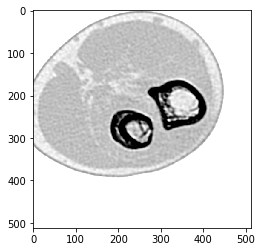

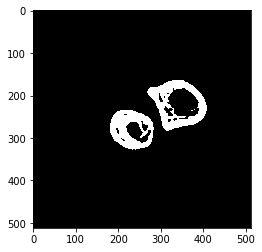

In [27]:
# and example of the data

import matplotlib.pyplot as pl

import numpy as np
import imageio

img = imageio.imread("data/tests/imgs/set6_111.png")
lab = imageio.imread("data/tests/labs/lab6_111.png")

pl.close("all")

pl.figure()
pl.imshow(img, cmap="gray")
pl.figure()
pl.imshow(lab, cmap="gray")
pl.show()

in the following cell, we're introducing another few functions to load the data:

* `build_names(path)`: list the files within a path
* `load_images(names)`: load a list of images and resize them to a `(X, Y, CH)` shaped array
* `load_batch(batch)`: loads all images in a batch and stackes them
* `proc_batch(batch, fun=None, fun_img=None, fun_lab=None)`: loads a batch of images and apply functions to them
* `gt_iterator(img_path, lab_path, size)`: loads all images within the `imgs` and `labs` dirs into batches

In [29]:
# load GT functions

import os


def build_names(path):
    """ Sorted list of files within a directory """
    files = os.listdir(path)
    files = sorted(files)
    return [os.path.join(path, file_name) for file_name in files]


def load_images(names):

    def _load_shape(name):
        img = imageio.imread(name)
        if img.shape[0] > 512:
            img = img[100:612, 100:612]
        if len(img.shape) == 2:
            img.shape = img.shape + (1, )
        return img

    return np.stack(tuple(_load_shape(name) for name in names))


def load_path(path):
    """ Builds an batched iterator of images and labels """

    return load_images(build_names(path))

In [31]:
img_path = "./data/train/imgs"
lab_path = "./data/train/labs"

val_img_path = "./data/valid/imgs"
val_lab_path = "./data/valid/labs"


def fun_img(arr):
    return arr.astype(np.float) / 255


def fun_lab(arr):
    return arr > .5


(1237, 512, 512, 1)
(1237, 512, 512, 1)
(359, 512, 512, 1)
(359, 512, 512, 1)


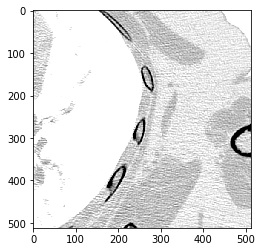

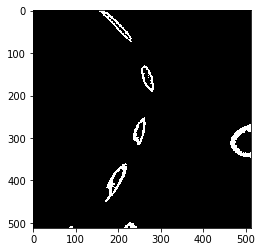

In [33]:
# example of batched GT


imgs = fun_img(load_path("data/train/imgs/"))
labs = fun_lab(load_path("data/train/labs/"))

imgs_test = fun_img(load_path("data/tests/imgs/"))
labs_test = fun_lab(load_path("data/tests/labs/"))


print(imgs.shape)
print(labs.shape)

print(imgs_test.shape)
print(labs_test.shape)

pl.close("all")
pl.figure()
pl.imshow(imgs[2, :, :, 0], cmap="gray")
pl.figure()
pl.imshow(labs[2, :, :, 0], cmap="gray")
pl.show()

In [34]:
# Building the model architecture

def build_fcnn(chan, classes, layers, **params):

    """
    parameters:
        * chan: (int) the number of channel in the images (1 for mono, 3 for RGB, etc)
        * layers: (list) the number of filters in each hidden layer
        * params: keras.layers.Conv2D key word args for the hidden layers
    """

    first, layers = layers[0], layers[1:]
    mod = Sequential()
    mod.add(Conv2D(first, input_shape=(None, None, chan), **params))

    for layer in layers:
        mod.add(Conv2D(layer, **params))

    # output layer
    mod.add(Conv2D(classes, (1, 1), activation='sigmoid'))

    return mod

In [ ]:
from scipy import signal

# .convolve2d()

In [36]:
mod_params = {
    "kernel_size": (3, 3),
    "kernel_initializer": 'glorot_uniform',
    "padding": "same",
    "activation": "relu",
}

# mod = build_fcnn(1, 1, [25, 40, 70, 130, 200], **mod_params)
mod = build_fcnn(1, 1, [16, 32, 64, 128, 128, 128], **mod_params)

In [37]:
mod.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.e-3, momentum=0.99, nesterov=True),
    metrics=['accuracy'])

mod_hist = mod.fit(
    imgs, labs,
    epochs=6,
    batch_size=10,
    validation_split=0.25,
    verbose=1)


Train on 927 samples, validate on 310 samples
Epoch 1/6
927/927 [==============================] - 47s 51ms/step - loss: 0.3443 - acc: 0.9254 - val_loss: 0.0729 - val_acc: 0.9796
Epoch 2/6
927/927 [==============================] - 45s 49ms/step - loss: 0.1164 - acc: 0.9669 - val_loss: 0.0660 - val_acc: 0.9796
Epoch 3/6
927/927 [==============================] - 44s 48ms/step - loss: 0.0870 - acc: 0.9669 - val_loss: 0.0478 - val_acc: 0.9796
Epoch 4/6
927/927 [==============================] - 44s 47ms/step - loss: 0.0694 - acc: 0.9669 - val_loss: 0.0411 - val_acc: 0.9796
Epoch 5/6
927/927 [==============================] - 43s 47ms/step - loss: 0.0569 - acc: 0.9669 - val_loss: 0.0365 - val_acc: 0.9796
Epoch 6/6
927/927 [==============================] - 43s 47ms/step - loss: 0.0466 - acc: 0.9669 - val_loss: 0.0324 - val_acc: 0.9796


dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


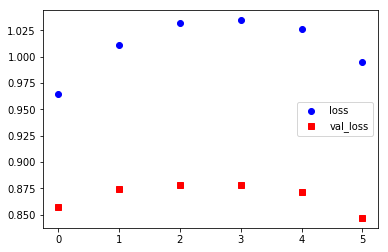

In [17]:
import matplotlib.pyplot as pl

print(mod_hist.history.keys())

pl.plot(mod_hist.history["loss"], "bo")
pl.plot(mod_hist.history["val_loss"], "rs")
pl.legend(["loss", "val_loss"])
pl.show()

In [67]:
# _ = next(val_batches)

# evaluation = [ for batch in itertools.islice(val_batches, 10, 20)]

evaluations = []
for num in range(30):
    dat = next(val_batches)
    evaluation = mod.evaluate(*dat, batch_size=5, verbose=1)
    evaluations.append(evaluation)

evaluations = np.array(evaluations)

15/15 [==============================] - 0s 14ms/step


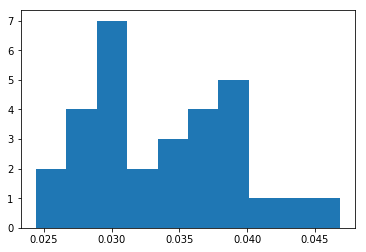

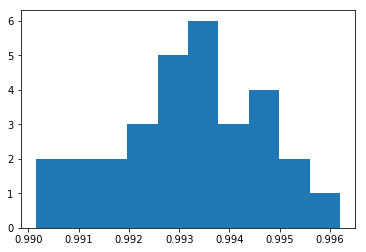

In [68]:
pl.close("all")

pl.hist(evaluations[:, 0])
pl.figure()
pl.hist(evaluations[:, 1])
pl.show()

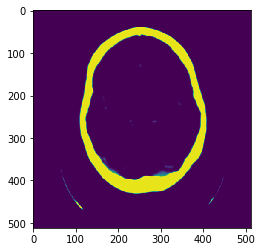

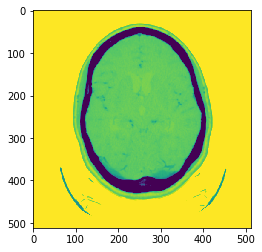

In [70]:
# imgs, labs = next(val_batches)
# pred = mod.predict(imgs)

num = 13
pl.imshow(pred[num, ..., 0])
pl.figure()
pl.imshow(imgs[num, ..., 0])
pl.show()